# Relax Data Science Take Home Challenge

## Import Libraries and datasets

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import pandas_profiling
import calendar

In [69]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [70]:
#pandas_profiling.ProfileReport(df)

In [71]:
ses = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [72]:
# pandas_profiling.ProfileReport(ses)

In [73]:
ses['user_id'].drop_duplicates().shape

(8823,)

In [74]:
# Are there the same number of unique users in each data set?

print('There are {} users who have ever used the application.'\
          .format(len(list(ses['user_id'].unique()))))

print('There are {} signed up for the application.'\
          .format(len(list(df['object_id'].unique()))))

print('There is a {} inactive users.'\
          .format(int(len(list(df['object_id'].unique()))) 
                  - int(len(list(ses['user_id'].unique())))))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a 3177 inactive users.


## Data Wrangling

In [75]:
ses['time_stamp'] = pd.to_datetime(ses['time_stamp']) - pd.to_timedelta(7, unit='d')

In [76]:
ses_stats = pd.Series([])

C:\Users\guzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [77]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = ses.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

In [78]:
ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [79]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

In [80]:
df['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

In [81]:
invited_users = df[df['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)

# Exploratory Data Analysis
## ------- > What percentage of the users are adopted?

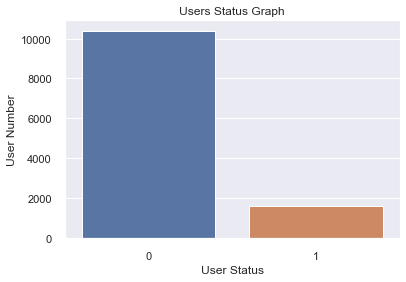

Total percentage of the adopted users are: 13.35 %


0    10398
1     1602
Name: adopted_user, dtype: int64

In [82]:
# Target Variable
sns.countplot(df['adopted_user'])
plt.title('Users Status Graph')
plt.xlabel('User Status')
plt.ylabel('User Number')
plt.show()

print('Total percentage of the adopted users are:', 
      100*df['adopted_user'].sum()/df['adopted_user'].count(),'%')

df['adopted_user'].value_counts()

In [83]:
def graph_df(x, y = 'bar', z = 0): 
    
    """
    This function creates graph for each feature in the dataset
    """
    
    feature = df.groupby(x).agg({'adopted_user':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['adopted_user mean'] = feature['adopted_user mean']*100
    feature.columns = [x, 'Total Users', 'Adopted User Number', 
                       '% of Adopted User in the Relevant Group'] 
    
    fig0, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    feature.set_index(feature[x], drop=True, inplace=True)
    feature['Total Users'].plot(kind = y, stacked = True, ax = ax1, 
                                   colormap = 'winter', rot = z)
    feature['% of Adopted User in the Relevant Group'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Adopted User status compared to' + " " + x  + " " + "Groups")
    ax1.set_xlabel(x)
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Users")
    ax2.set_ylabel("Adopted User Percentage in the Relevant Group")
    ax2.yaxis.label.set_color('red')
    plt.tight_layout()
    plt.show()

## -------- > Analyze opted_in_to_mailing_list with adopted users

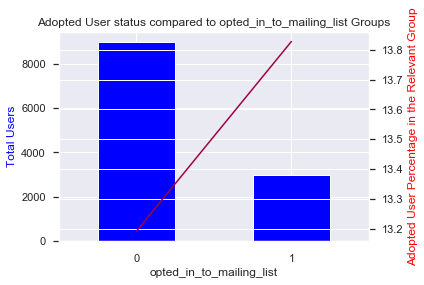

opted_in_to_mailing_list
0    0.131912
1    0.138277
Name: adopted_user, dtype: float64

In [84]:
# Analysis of adopted user and whether they opted into marketing emails
graph_df('opted_in_to_mailing_list')

#percentage of engaged users by email opt in
df[['opted_in_to_mailing_list','adopted_user']].groupby('opted_in_to_mailing_list')['adopted_user'].mean()

## -------- > Analyze enabled_for_marketing_drip with adopted users

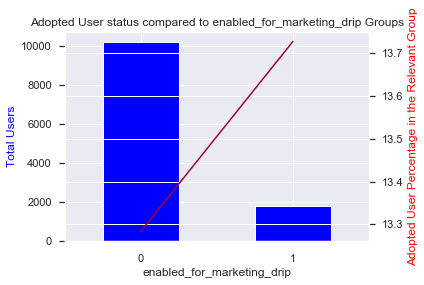

enabled_for_marketing_drip
0    0.132837
1    0.137277
Name: adopted_user, dtype: float64

In [85]:
# Analysis of adopted users with regular promotional marketing email
graph_df('enabled_for_marketing_drip')

#percentage of engaged users by email opt in
df[['enabled_for_marketing_drip','adopted_user']].groupby('enabled_for_marketing_drip')['adopted_user'].mean()

## -------- > Analyze creation_source with adopted users

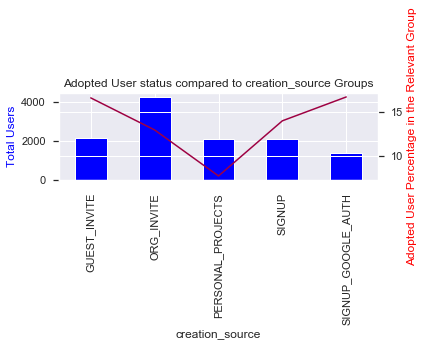

creation_source
GUEST_INVITE          0.166436
ORG_INVITE            0.129995
PERSONAL_PROJECTS     0.077688
SIGNUP                0.140393
SIGNUP_GOOGLE_AUTH    0.167509
Name: adopted_user, dtype: float64

In [86]:
# Analysis of adopted users with creation source
graph_df('creation_source', z= 90)

#percentage of engaged users by creation source
df[['creation_source','adopted_user']].groupby('creation_source')['adopted_user'].mean()

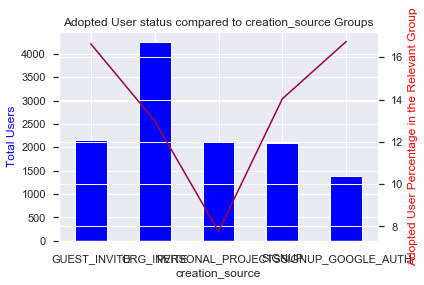

In [87]:
graph_df('creation_source')

People with Personal Projects are extremely less likely to be an adopted user as compared to other creation source methods. But since this does not help us in identifying adopted users, this too, isn't a very useful feature.

## ---------> Analyze invited_users with adopted users

In [88]:

df['invited'] = df['object_id'].apply(lambda x: 1 if x in invited_users else 0)

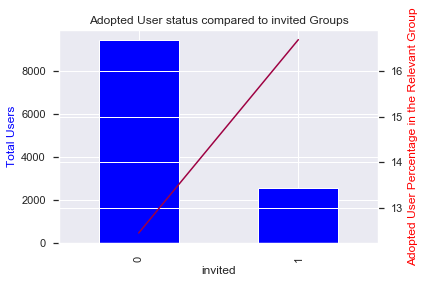

invited
0    0.124417
1    0.166927
Name: adopted_user, dtype: float64

In [89]:
# Analysis of adopted users with invited users
graph_df('invited', z= 90)

#percentage of engaged users by creation source
df[['invited','adopted_user']].groupby('invited')['adopted_user'].mean()

People who have invited other users have a slightly larger percentage chance of being an adopted user.

## --------- > Analyze email domain with adopted users

In [90]:

df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df['email'] = df['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

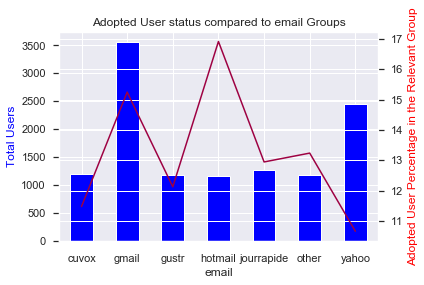

email
cuvox         0.114809
gmail         0.152442
gustr         0.121289
hotmail       0.169099
jourrapide    0.129468
other         0.132378
yahoo         0.106661
Name: adopted_user, dtype: float64

In [91]:
# Analysis of adopted users with email domains.
graph_df('email')

#percentage of engaged users by email domain
df[['email','adopted_user']].groupby('email')['adopted_user'].mean()

People who have signed up using hotmail are most likely to become adopted users whereas people with yahoo IDs are the least likely. However, since the difference is so small, it might be entirely possible that these observations are due to noise.

# -------> Analyze last_session_creation_time and adopted users

In [92]:
#sns.set(style="darkgrid", color_codes=True)
#j = sns.jointplot(x='last_session_creation_time', y='adopted_user', data=df, kind='reg', height=8)
#j.annotate(stats.pearsonr)
#plt.show()

There seems to be a medium correlation between the last session creation time and the target variable. This may be the most important feature to predict our adopted users as all the other variables have been extremely weak in explaining the target variable.

# Feature Engineering

In [93]:
df = df.set_index('object_id')


In [94]:
df = df.drop('name', axis=1)


In [95]:
df['email'].value_counts()


gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [96]:
df = df.drop('invited_by_user_id', axis=1)


In [97]:
df['org_id'].value_counts().shape


(417,)

In [98]:
df[df['adopted_user'] == 1]['org_id'].value_counts().shape


(400,)

In [99]:
df = df.drop('org_id', axis=1)


In [100]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [101]:
df = df.drop('creation_time', axis=1)

In [102]:
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [103]:
df = pd.get_dummies(df, prefix='is')


In [104]:
df['last_session_creation_time'].fillna(0, inplace = True)


# Modelling
Since we have a small feature set and sample size, Kneighbors and RandomForestClassifier are both good choices for this data set. However, we have a mix of categorical and numerical data so RandomForestClassifier will be easiest to implement. I will use the metric for this classification problem ROC_AUC.

In [105]:
# Split the data training and test set
X = df.drop('adopted_user', axis = 1)
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0, stratify=y)

In [106]:
pipe = Pipeline([('selectKBest', SelectKBest()), ('clf', RandomForestClassifier())])
param_grid = {
    'clf__n_estimators' : range(1,10,1),
    'selectKBest__k' : range(2,12,1),
    'clf__class_weight' : ['balanced', 'balanced_subsample'],
    'clf__random_state' : [21]
}

grid =GridSearchCV(pipe, param_grid, cv=5, scoring = 'roc_auc' )
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectKBest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x0000022BC71F8B88>)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
  

In [107]:
grid.best_score_


0.9373681795649393

In [108]:
y_pred = grid.predict(X_test)
grid.score(X_test, y_test)

0.9427379807692308

In [109]:
grid.best_params_

{'clf__class_weight': 'balanced',
 'clf__n_estimators': 9,
 'clf__random_state': 21,
 'selectKBest__k': 11}

## Feature Importance

Whatever coefficients the classifier has assigned to the features will indicate which ones it found more useful in making the correct classifications.

In [110]:
clf = RandomForestClassifier(n_estimators=9, class_weight='balanced', random_state=21)

In [111]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [112]:
# Feature importance as a table
pd.DataFrame(clf.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
last_session_creation_time,0.726760
is_5,0.038980
opted_in_to_mailing_list,0.015106
enabled_for_marketing_drip,0.013774
invited,0.012147
is_2014,0.011667
is_1,0.010430
is_PERSONAL_PROJECTS,0.009963
is_2,0.009273
is_3,0.009137


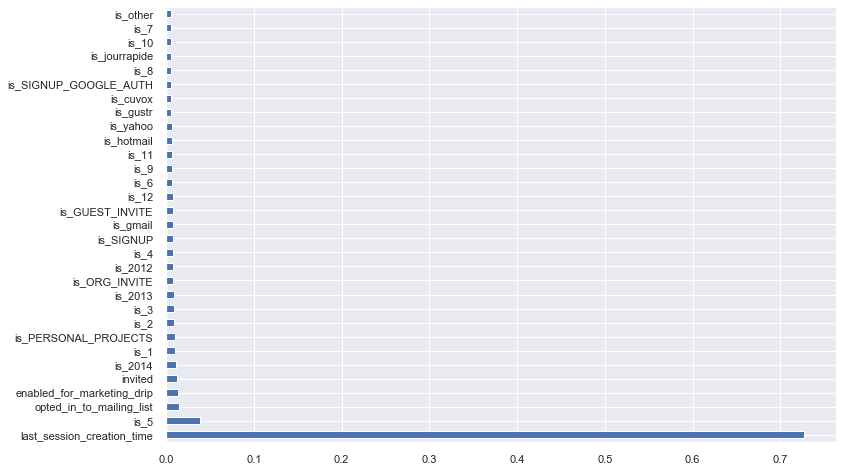

In [113]:
# Feature importance as a graph
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(clf.feature_importances_, index = X_train.columns)
feat_importances.nlargest(32).plot(kind='barh')

The most important feature to predict user adoption is last_session_creation_time.

## Conclusion

From the analysis and the predictive modeling that we have performed above, the results can be summarized as follows:

86% of our userbase are non adopted users. This clearly indicates that there is a lot that can be done to decrease this proportion relative to the number of adopted users.

last_session_creation_time is the most important feature when it comes to predicting adopted users. It accounts for more than 72% of the importance in our Random Forest Classifier.

All the other features have close to zero importance and do not explain the target variable well.